<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-основных-библиотек-и-данных.-Изучение-и-анализ-данных" data-toc-modified-id="Импорт-основных-библиотек-и-данных.-Изучение-и-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт основных библиотек и данных. Изучение и анализ данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-файлов-с-данными" data-toc-modified-id="Импорт-библиотек-и-файлов-с-данными-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек и файлов с данными</a></span></li><li><span><a href="#Импорт-и-изучение-данных" data-toc-modified-id="Импорт-и-изучение-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Импорт и изучение данных</a></span></li><li><span><a href="#Изучение-признаков-в-разрезе-факта-оттока-в-текущем-месяце" data-toc-modified-id="Изучение-признаков-в-разрезе-факта-оттока-в-текущем-месяце-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Изучение признаков в разрезе факта оттока в текущем месяце</a></span></li></ul></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span><ul class="toc-item"><li><span><a href="#Разделение-данных-выборки-и-обучение-моделей" data-toc-modified-id="Разделение-данных-выборки-и-обучение-моделей-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Разделение данных выборки и обучение моделей</a></span></li><li><span><a href="#Оценка-моделей-логистической-регрессии-и-случайного-леса" data-toc-modified-id="Оценка-моделей-логистической-регрессии-и-случайного-леса-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Оценка моделей логистической регрессии и случайного леса</a></span></li></ul></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Описание проекта
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Задача в рамках проекта — провести анализ и подготовить план действий по удержанию клиентов.

А именно:
научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;  
сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;  
проанализировать основные признаки, наиболее сильно влияющие на отток;  
сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:  

1) выделить целевые группы клиентов;  
2) предложить меры по снижению оттока;  
3) определить другие особенности взаимодействия с клиентами.  

## Импорт основных библиотек и данных. Изучение и анализ данных
### Импорт библиотек и файлов с данными

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import roc_auc_score


Делаем преднастройку - ограничиваем видимость для цифр с плавающей запятой в две цифры, а также настраиваем отображение всех колонок.

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)

### Импорт и изучение данных

In [3]:
gym_churn = pd.read_csv('gym_churn.csv')

Для изучения данных будем использовать функцию inspect.

In [4]:
def inspect(df):
    display(df.sample(10)) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'date' in column_name in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df

Описание столбцов в датафрейме:  
'gender' — пол;  
'Near_Location' — проживание или работа в районе, где находится фитнес-центр;  
'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);  
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);  
'Phone' — наличие контактного телефона;  
'Age' — возраст;  
'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).  
'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);  
'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);  
'Group_visits' — факт посещения групповых занятий;  
'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;  
'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;  
'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.  
'Churn' — факт оттока в текущем месяце.  

In [5]:
inspect(gym_churn)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3434,1,1,0,0,1,6,0,28,230.84,6.00,1,1.30,1.39,1
3509,0,0,1,0,0,6,1,30,275.30,6.00,2,2.22,2.29,0
1529,1,1,0,1,1,1,0,25,138.30,1.00,2,0.48,0.40,0
2108,0,0,1,1,1,1,0,31,224.46,1.00,1,0.89,0.75,0
3107,0,1,1,1,1,6,0,33,300.79,6.00,10,0.53,0.70,0
1475,1,1,1,1,1,12,1,29,187.01,11.00,4,1.36,1.49,0
2997,0,0,0,0,1,1,0,26,230.69,1.00,2,1.61,0.16,1
2443,0,1,1,0,1,6,1,34,349.36,6.00,11,2.42,2.23,0
347,0,0,1,0,1,6,0,33,42.89,6.00,4,1.47,1.29,0
1654,1,1,1,0,1,6,0,31,227.06,6.00,4,2.82,2.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


1    3381
0     619
Name: near_location, dtype: int64

**************************************************


0    2053
1    1947
Name: partner, dtype: int64

**************************************************


0    2766
1    1234
Name: promo_friends, dtype: int64

**************************************************


1    3614
0     386
Name: phone, dtype: int64

**************************************************


1     2207
12     960
6      833
Name: contract_period, dtype: int64

**************************************************


0    2351
1    1649
Name: group_visits, dtype: int64

**************************************************


29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: age, dtype: int64

**************************************************


14.23     1
17.08     1
278.20    1
120.46    1
130.71    1
         ..
92.33     1
147.62    1
24.92     1
56.13     1
178.86    1
Name: avg_additional_charges_total, Length: 4000, dtype: int64

**************************************************


1.00     2207
6.00      645
12.00     524
11.00     181
5.00      130
10.00      82
9.00       73
4.00       58
8.00       38
7.00       25
3.00       23
2.00       14
Name: month_to_end_contract, dtype: int64

**************************************************


1     843
2     610
3     490
0     487
4     383
5     273
6     220
7     167
8     111
9     100
10     76
12     53
11     48
13     28
15     24
14     24
16     15
17     11
20      7
19      7
18      7
21      5
23      2
24      2
26      2
22      2
31      1
27      1
29      1
Name: lifetime, dtype: int64

**************************************************


0.00    88
0.02     1
2.18     1
1.98     1
1.67     1
        ..
1.00     1
1.73     1
1.78     1
3.79     1
1.10     1
Name: avg_class_frequency_total, Length: 3913, dtype: int64

**************************************************


0.00    181
1.33      1
2.63      1
1.80      1
1.52      1
       ... 
2.36      1
2.46      1
0.67      1
1.05      1
1.04      1
Name: avg_class_frequency_current_month, Length: 3820, dtype: int64

**************************************************


0    2939
1    1061
Name: churn, dtype: int64

**************************************************


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,1
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0


Всего в полученном массиве данных 4000 строк. Пропуски и дубликаты в полученном массиве данных отсутствуют.  
Половина характеристик представлена в виде булевых значений в числовом формате.  
В связи с малым объемом файла, нет необходимости в изменении типа данных отдельных столбцов.  

По полученной детализации в файле можно предположить, что выбросы присутствуют в столбце Lifetime (при третей квантили в 5 месяцев и стандартном отклонении 3,75 максимальное значение по столбцу - 31), Avg_class_frequency_total и Avg_class_frequency_current_month (75% данных в пределах прим. до 2,5 дней в неделю при максимальном значении чуть более 6 и стандартном отклонении в районе 1).  
Возможно, выбросы данных в этих столбцах в дальнейшем потребуется удалить, т.к. поведение этих клиентов не характерно для подавляющего большинства посетителей фитнес-клуба.  

Дополнительно можно обратить внимание на достаточно низкое количество наблюдений с целевым признаком. Только чуть больше четверти пользователей из выборки имеют признак Churn, Что желательно учесть при обучении модели. 

Построим графики разброса по параметрам Lifetime, Avg_class_frequency_total и Avg_class_frequency_current_month для визуализации распределения значений в этих столбцах.  
Автоматизируем построение графиков с помощью функции scatter_plot.

In [6]:
def scatter_plot(column):
    # серия из чисел по количеству наблюдений
    x_values = pd.Series(range(0, len(gym_churn[column])))
    # построение графика разброса
    plt.title('Разброс значений по столбцу ' + column)
    plt.scatter(x_values, gym_churn[column]) 
    plt.show()
    # расчет перцентилей
    print('95 и 99 перцентили:', np.percentile(gym_churn[column], [95, 99]))

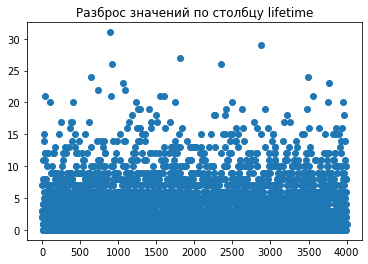

95 и 99 перцентили: [11. 17.]


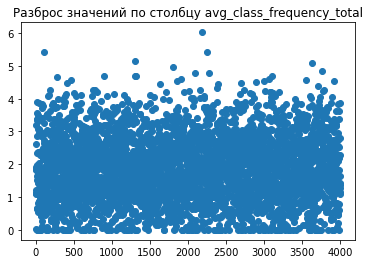

95 и 99 перцентили: [3.53564837 4.19757925]


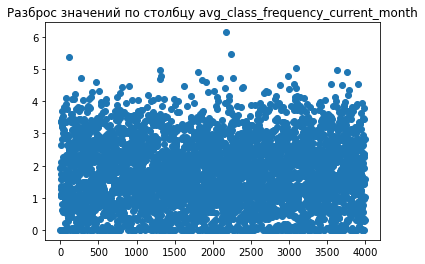

95 и 99 перцентили: [3.54906154 4.18575779]


In [7]:
columns = ['lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
for col in columns:
    scatter_plot(col)

В данных присутствуют выбросы. В дальнейшем, при необходимости, избавимся от них.

### Изучение признаков в разрезе факта оттока в текущем месяце 
Проверим средние значения признаков в разбивке по группам на основе факта оттока клиента.  
Для этого воспользуемся методом .describe() с фильтром по столбцу churn.

In [8]:
gym_churn.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


По полученным средним значениям можно сделать следующие выводы:  
1) Пол не является определяющим признаком оттока клиентов;  
2) Если фитнес-клуб находится в районе проживания или работы клиента, вероятность оттока клиента чуть ниже;  
3) Вероятность оттока клиента выше, если он не является сотрудником компании-партнёра клуба;  
4) Если клиент был привлечён по акции "Приведи друга", то он почти в два раза чаще остается клиентом клуба. Аналогично в случае, если клиент посещает групповые занятия;  
5) Отток более характерен для клиентов, приобретающих абонемент на менее длительный период. Также чем меньше остаточная длительность действующего абонемента, тем выше шанс оттока клиента;  
6) Средний возраст для обоих групп различается незначительно. По средним значениям можно строить предположение, что более молодые клиенты более склонны к оттоку;   
7) Чем больше клуб получает выручки от попутных услуг с клиента, тем меньше шанс оттока клиента; 
8) По среднему значению lifetime можно говорить, что чаще "отваливаются" клиенты, которые недавно обратились в первый раз в фитнес-клуб (в течение месяца);
9) Отток чаще наблюдается у клиентов с более низкой средней частостой посещения клуба. При этом прослеживается динамика сокращения количества посещений до 1 раза в неделю для клиентов, которые "отваливаются" в течение месяца. Для клиентов, посещающих клуб регулярно, средняя частота посещения составляет 2 раза в неделю. 

Далее проверим корреляцию признаков и их распределение. 

In [9]:
gym_churn.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

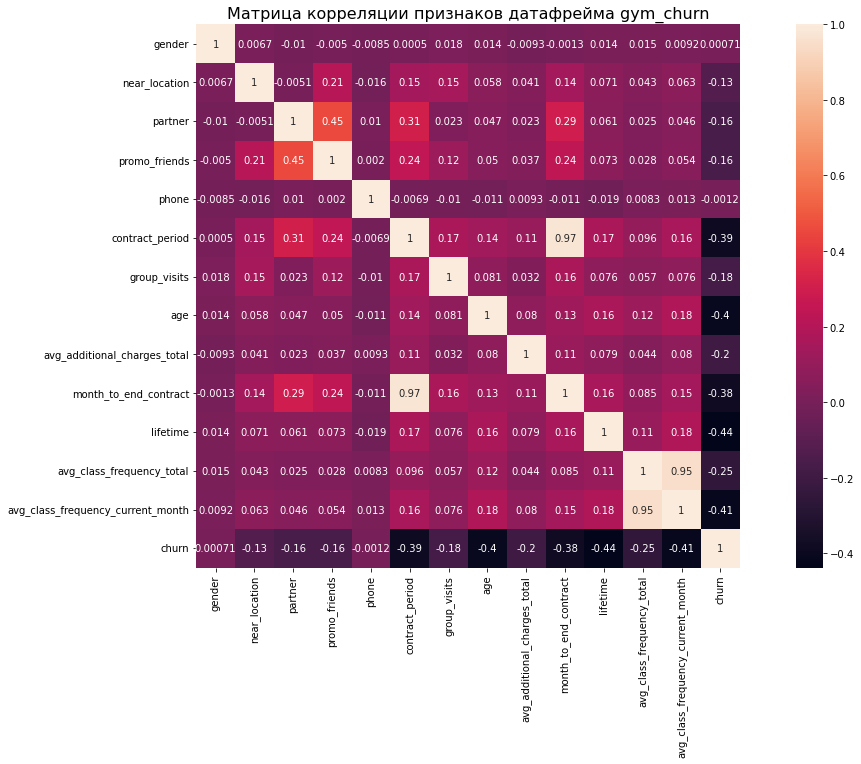

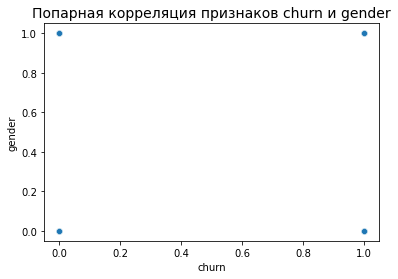

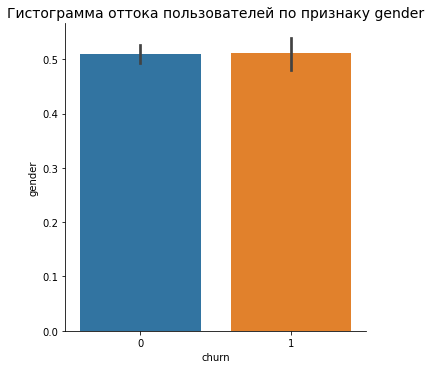

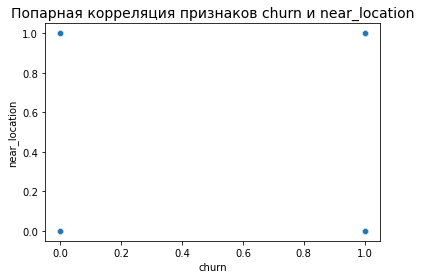

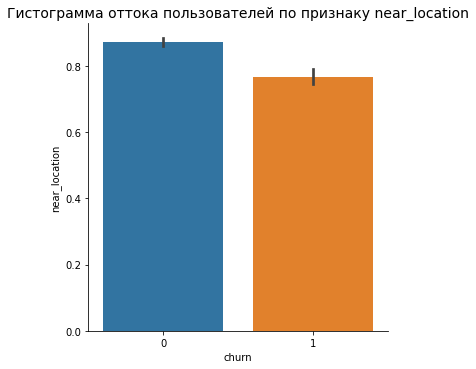

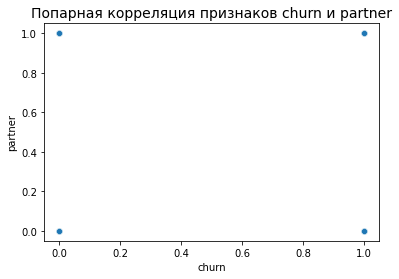

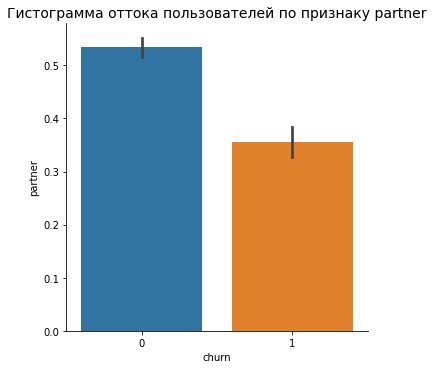

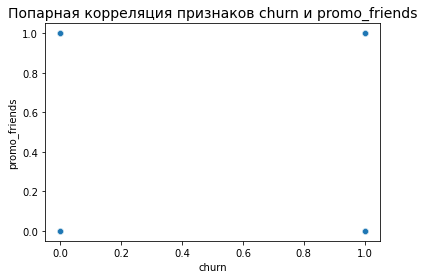

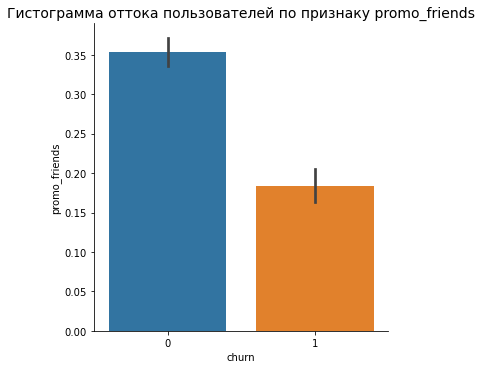

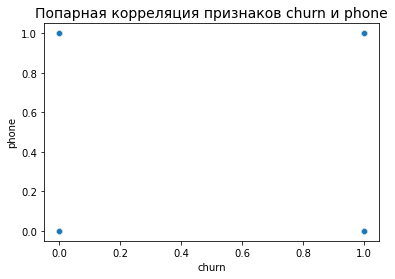

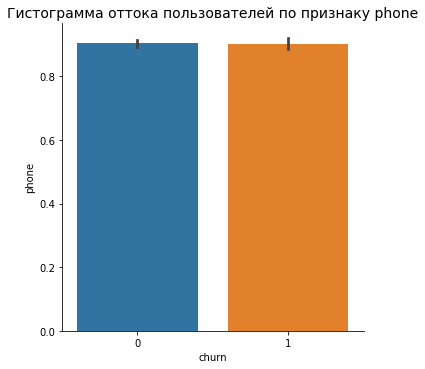

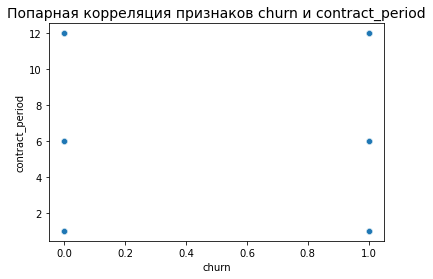

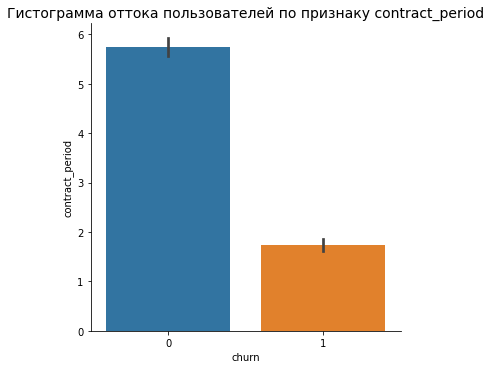

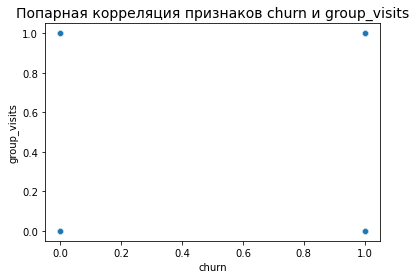

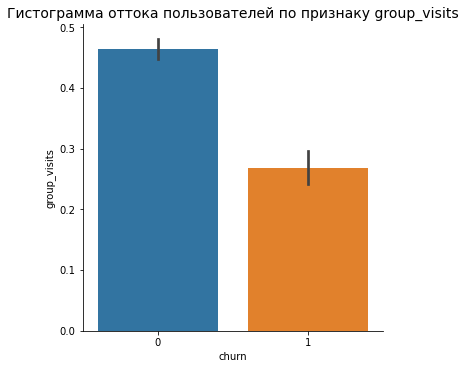

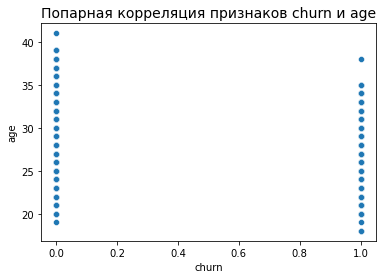

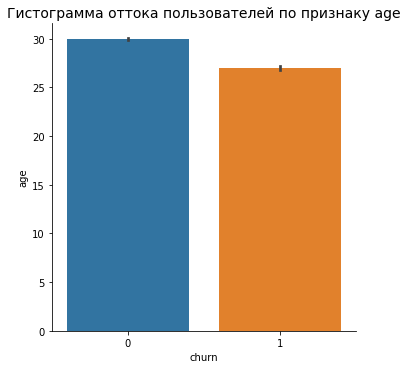

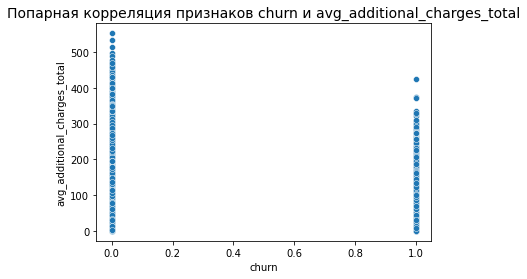

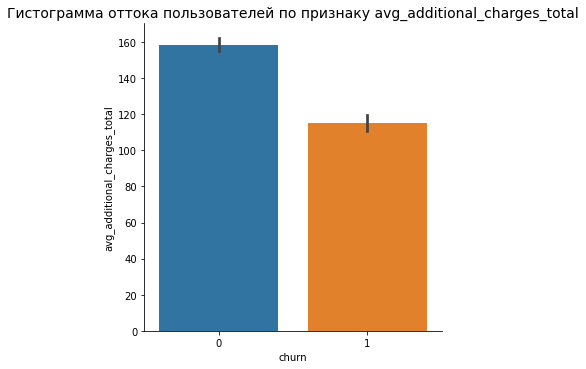

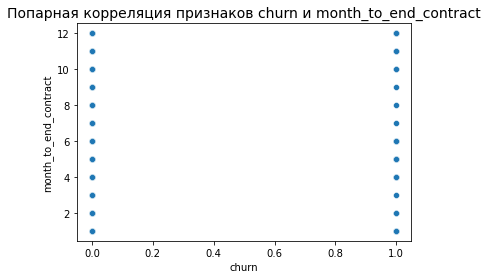

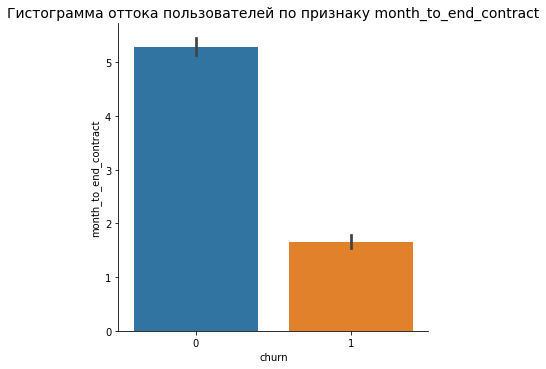

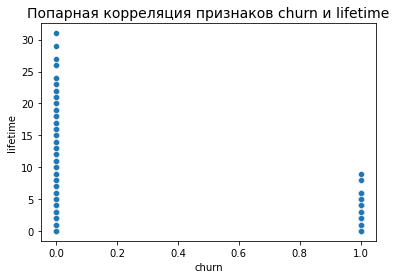

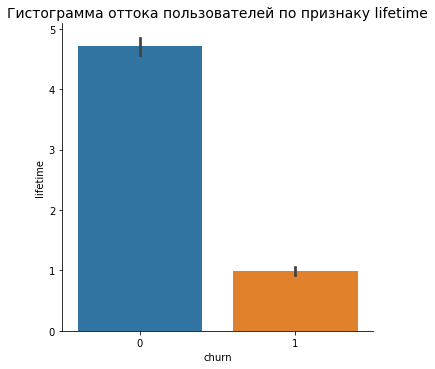

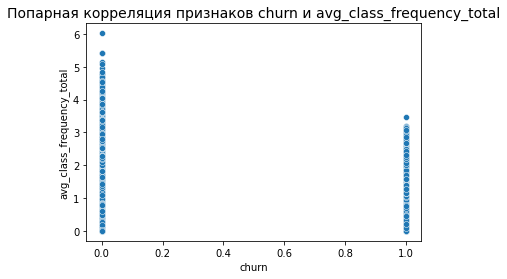

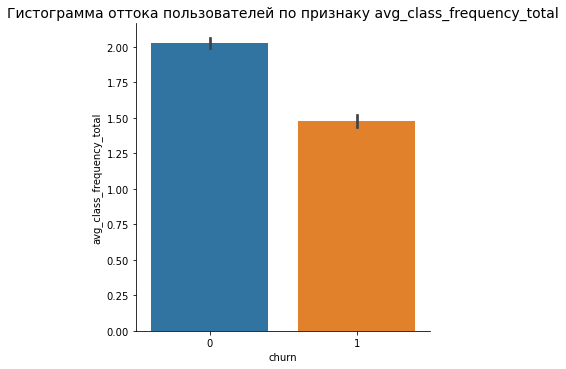

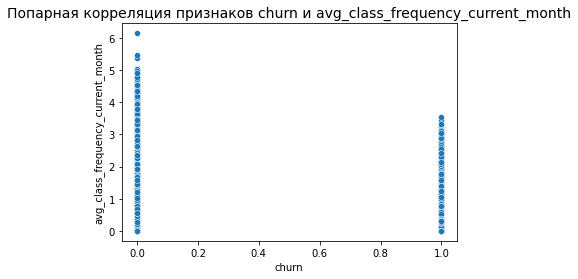

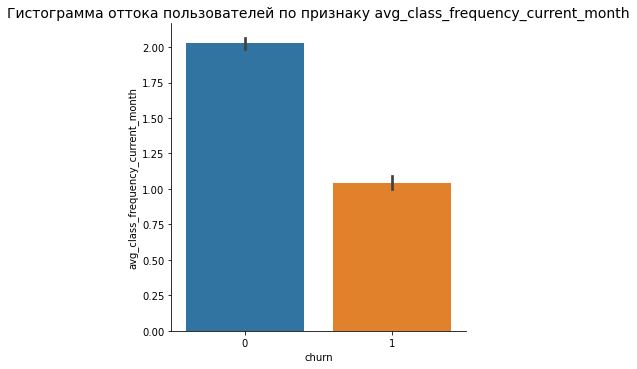

In [10]:
cm = gym_churn.corr() #вычисляем матрицу корреляций

plt.figure(figsize=(20, 10))
plt.title('Матрица корреляции признаков датафрейма gym_churn', fontsize=16)
sns.heatmap(cm, annot=True, square=True)
plt.show()

#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
for col in gym_churn.drop('churn', axis = 1).columns:
    sns.scatterplot(x=gym_churn['churn'], y=gym_churn[col]) 
    plt.title('Попарная корреляция признаков churn и ' + col, fontsize=14)
    sns.catplot(x='churn', y=col, data=gym_churn, kind="bar")
    plt.title('Гистограмма оттока пользователей по признаку ' + col, fontsize=14)
    plt.show()

По матрице корреляции видим очень сильную связь между следующими показателями:
1) contract_period - month_to_end_contract (0,97);  
2) avg_class_frequency_total - avg_class_frequency_current_month (0,95);  
Примем это во внимание при построении модели.  

Также видим сильную взаимосвязь оттока клиентов churn с признаками contract_period, age, month_to_end_contract, lifetime и avg_class_frequency_current_month.  
Гистограммы и графики распределения признаков подтверждают ранее полученную информацию.

Удалим из массива данных явно коррелирующие с другими признаками датафрейма avg_class_frequency_total и contract_period.  
Их включение в модель не целесообразно, т.к. эти признаки не внесут ощутимый вклад в расчеты модели.

In [11]:
gym_churn_clear = gym_churn.drop(['avg_class_frequency_total', 'contract_period'], axis=1)

## Построение модели прогнозирования оттока клиентов
### Разделение данных выборки и обучение моделей
Далее построим модель бинарной классификации клиентов с целевым признком - факт оттока клиента в следующем месяце.  
Модель будет обучена двумя способами: логистической регрессией и случайным лесом.  
Обучение модели двумя способами необходимо для сравнения их результатов посредством метрик accuracy, precision и recall. На основе этих характеристик можно будет сделать вывод о качетсве моделей для выбора наиболее точно описывающей наблюдения валидационной выборки (дающие наиболее близкие к имеющимся целевым значениям результаты). 

Разделим данные на признки Х и целевую переменную у, после чего разобьем эти данные на обучающую и валидационную выборки по принципу 80% выборки - общучающие данные, 20% - валидационные. 

In [12]:
# формируем массив признаков и массив с целевой переменной
X_clear = gym_churn_clear.drop('churn', axis=1)
y_clear = gym_churn_clear['churn']
# делим признаки на выборки
X_train_clear, X_test_clear, y_train_clear, y_test_clear = train_test_split(
    X_clear, y_clear, test_size=0.2, random_state=0
)

In [13]:
print('Доля клиентов с признаком churn в обучающей выборке', y_train_clear.sum()/y_train_clear.count())
print('Доля клиентов с признаком churn в валидационной выборке',y_test_clear.sum()/y_test_clear.count())


Доля клиентов с признаком churn в обучающей выборке 0.2696875
Доля клиентов с признаком churn в валидационной выборке 0.2475


Перепроверим корректность разбивки:

In [14]:
print('Размер таблицы X_train:', X_train_clear.shape)
print('Размер таблицы X_test:', X_test_clear.shape)

Размер таблицы X_train: (3200, 11)
Размер таблицы X_test: (800, 11)


Разделение данных на обучающую и валидационную произведено корректно.  

Далее обучим модели двумя способами.  
Сначала обучим модель логистической регрессии lr_model_clear.

In [15]:
# задаем алгоритм модели
lr_model_clear = LogisticRegression(solver='liblinear') 
# обучаем модель на обучающих данных 
lr_model_clear.fit(X_train_clear, y_train_clear)
# делаем прогнозы по модели 
lr_predictions_clear = lr_model_clear.predict(X_test_clear) 
lr_probabilities_clear = lr_model_clear.predict_proba(X_test_clear)[:, 1]

Обучаем модель случайного леса rf_model_clear.

In [16]:
# задаем алгоритм модели
rf_model_clear = RandomForestClassifier(random_state=0)
# обучим модель решающего дерева
rf_model_clear.fit(X_train_clear, y_train_clear)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions_clear = rf_model_clear.predict(X_test_clear)
rf_probabilities_clear = rf_model_clear.predict_proba(X_test_clear)[:, 1]

### Оценка моделей логистической регрессии и случайного леса
Как было указано ранее, для оценки моделей будут использоваться метрики accuracy, precision и recall.  
Определяем функцию для расчета метрик.

In [17]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [18]:
# выведем все метрики
print_all_metrics(
    y_test_clear,
    lr_predictions_clear,
    lr_probabilities_clear,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test_clear,
    rf_predictions_clear,
    rf_probabilities_clear,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.80
	Recall: 0.79
Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.79


На основе полученных метрик можно говорить о том, что модель случайного леса показывает чуть лучшие результаты.  
Ее показатель доли правильных ответов (accuracy - доля верных полжительных и верных отрицательных среди всех полученных результатов) выше на 0,1, а показатель точности (precision - доля правильных положительных ответов среди всех положительных ответов модели)  лучше на 0,3.  
Показатель полноты (recall - доля верных положительных среди всех реально положительных результатов) одинаков для обоих моделей.  

Чем ближе все три указанные метрики к единице, тем более качественно модель строит предположения. В нашем случае у модели случайного леса rf_model показатель accuracy составляет 0,91, precision - 0,83, а recall - 0,79.  
Полученные результаты - достаточно высокие. Только в 9 случаях из 100 модель даст неверный результат.  
При необходимости в более точных прогнозах со стороны заказичка в дальнейшем можно произвести оценку качества классификатора с использованием метрики AUC-ROC.  

Попробуем включить стратификацию признаков при делении данных на обучающую и валидационную выборку, и проверим итоги.

In [19]:
# делим признаки на выборки с учетом стратификации
X_train_clear, X_test_clear, y_train_clear, y_test_clear = train_test_split(
    X_clear, y_clear, test_size=0.2, random_state=0 ,stratify=y_clear
)
print('Доля клиентов с признаком churn в обучающей выборке', y_train_clear.sum()/y_train_clear.count())
print('Доля клиентов с признаком churn в валидационной выборке',y_test_clear.sum()/y_test_clear.count())


Доля клиентов с признаком churn в обучающей выборке 0.2653125
Доля клиентов с признаком churn в валидационной выборке 0.265


In [20]:
# задаем алгоритм модели логистической регрессии
lr_model_clear = LogisticRegression(solver='liblinear') 
# обучаем модель на обучающих данных 
lr_model_clear.fit(X_train_clear, y_train_clear)
# делаем прогнозы по модели 
lr_predictions_clear = lr_model_clear.predict(X_test_clear) 
lr_probabilities_clear = lr_model_clear.predict_proba(X_test_clear)[:, 1]

# задаем алгоритм модели случайного реса
rf_model_clear = RandomForestClassifier(random_state=0)
# обучим модель решающего дерева
rf_model_clear.fit(X_train_clear, y_train_clear)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions_clear = rf_model_clear.predict(X_test_clear)
rf_probabilities_clear = rf_model_clear.predict_proba(X_test_clear)[:, 1]

In [21]:
# выведем все метрики
print_all_metrics(
    y_test_clear,
    lr_predictions_clear,
    lr_probabilities_clear,
    title='Метрики для модели логистической регрессии по стратифицированным данным:',
)

print_all_metrics(
    y_test_clear,
    rf_predictions_clear,
    rf_probabilities_clear,
    title='Метрики для модели случайного леса по стратифицированным данным:',
)

Метрики для модели логистической регрессии по стратифицированным данным:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
Метрики для модели случайного леса по стратифицированным данным:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.80


Результаты улучшились. При включении стратификации логистическая регрессия показывает лучший результат. 

Для эксперимента попробуем построить модели без исключения коррелирующих столбцов avg_class_frequency_total и contract_period. Логистическая регрессия при помощи регуляризации сгладит проблему.  
Стратифиация отключена. 

In [22]:
# формируем массив признаков и массив с целевой переменной
X = gym_churn.drop('churn', axis=1)
y = gym_churn['churn']
# делим признаки на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [23]:
# задаем алгоритм модели
lr_model = LogisticRegression(solver='liblinear') 
# обучаем модель на обучающих данных 
lr_model.fit(X_train, y_train)
# делаем прогнозы по модели 
lr_predictions = lr_model.predict(X_test) 
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

In [24]:
# задаем алгоритм модели
rf_model = RandomForestClassifier(random_state=0)
# обучим модель решающего дерева
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [25]:
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)

print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


Включим стратификацию при разделении выборки, посмотрим итоги с ней. 

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0 ,stratify=y
)

# задаем алгоритм модели логистической регрессии
lr_model = LogisticRegression(solver='liblinear') 
# обучаем модель на обучающих данных 
lr_model.fit(X_train, y_train)
# делаем прогнозы по модели 
lr_predictions = lr_model.predict(X_test) 
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

# задаем алгоритм модели случайной выборки
rf_model = RandomForestClassifier(random_state=0)
# обучим модель решающего дерева
rf_model.fit(X_train, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии по стратифицированным данным:',
)
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса по стратифицированным данным:',
)

Метрики для модели логистической регрессии по стратифицированным данным:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.83
Метрики для модели случайного леса по стратифицированным данным:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


Результаты снова улучшились при включении стратификации на этапе разделения данных.  
Интересное наблюдение - при построении моделей по всем признакам показатель Accuracy остался неизменен, но для обоих моделей улучшились Precision и Recall.

Обе модели показали наилучшие результаты без исключения коррелирующих столбцов и при стратификации целевого признака на этапе разделения данных на обучающую и валидационную выборку.  
Также проверим характеристику ROC_AUC для последних двух моделей. 

In [27]:
print('ROC_AUC для модели логистической регрессии по стратифицированным данным с включением в модель всех признаков: {:.2f}'
      .format(roc_auc_score(y_test, lr_probabilities)))
print('ROC_AUC для модели случайного леса по стратифицированным данным с включением в модель всех признаков: {:.2f}'
      .format(roc_auc_score(y_test, rf_probabilities)))

ROC_AUC для модели логистической регрессии по стратифицированным данным с включением в модель всех признаков: 0.98
ROC_AUC для модели случайного леса по стратифицированным данным с включением в модель всех признаков: 0.97


Также, модель логистической регрессии показывает лучшие результаты. 

## Кластеризация клиентов
На последнем этапе работы нам необходимо произвести кластеризацию клиентов.  
Для этих целей за основу будет взят используемый ранее массив gym_churn, но без характеристики churn (т.к. кластеризация не должна ориентироваться на признак оттока для разделения всех клиентов на категории). Новый массив назовем gym.

In [28]:
gym = gym_churn.drop('churn', axis=1)
gym

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60


Первый шаг кластеризации - старндартизация данных с использованием функции StandardScaler.  
После стандартизации, на основе данных построим матрицу расстояний и нарисуем дендрограмму используя классы модели кластеризации linkage() и dendrogram().

In [29]:
# создаём объект класса scaler (нормализатор)
scaler = StandardScaler() 
# обучаем нормализатор и преобразуем набор данных 
X_sc = scaler.fit_transform(gym) 

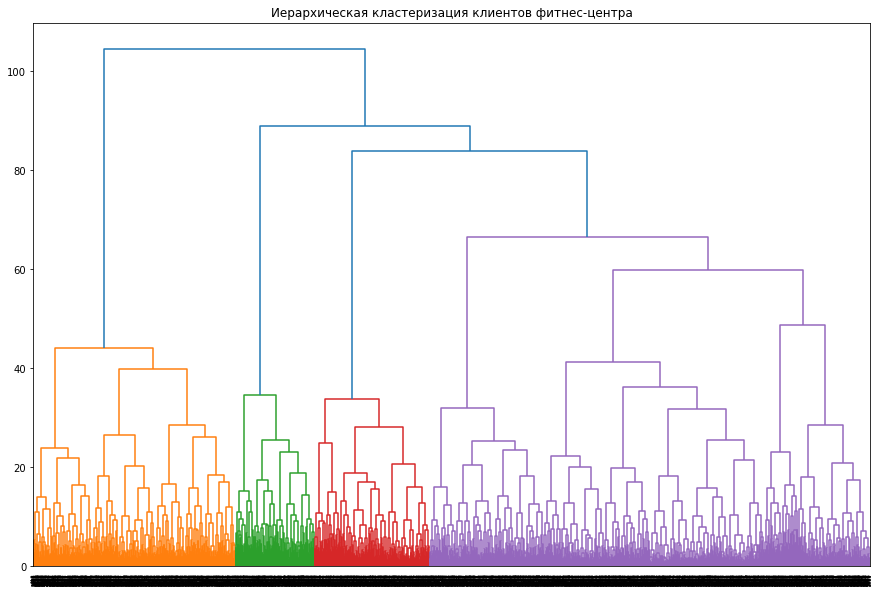

In [30]:
# формируем таблицу расстояний между объектами 
linked = linkage(X_sc, method = 'ward') 
# рисуем дендограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-центра')
plt.show() 

Визуализация дендрограммы предлагает деление всех клиентов фитнес-клуба на четыре категории, одна из которых по размеру составляет около половины от общего количества клиентов.  
На субъективный взгляд, самую большую группу клиентов необходимо поделить на две или на три подгруппы.  

С помощью алгоритма K-Means спрогнозируем кластеры клиентов.  
По полученной от заказчика задаче требуется разделить всех клиентов на 5 кластеров. 

In [31]:
# задаём модель K-Means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений 
labels =  km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym['cluster_km'] =labels

In [32]:
gym

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,cluster_km
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,1
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,3
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,3
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0


После разделения всех клиентов на 5 кластеров проверим средние значения по признакам.

In [33]:
# выводим статистику по средним значениям наших признаков по кластеру
print(gym.groupby('cluster_km').mean())

            gender  near_location  partner  promo_friends  phone  \
cluster_km                                                         
0             0.50           0.96     0.78           0.57   1.00   
1             0.52           0.86     0.47           0.31   0.00   
2             0.50           0.00     0.46           0.08   1.00   
3             0.49           1.00     0.35           0.24   1.00   
4             0.56           0.98     0.36           0.23   1.00   

            contract_period  group_visits   age  avg_additional_charges_total  \
cluster_km                                                                      
0                     10.89          0.54 29.98                        160.76   
1                      4.79          0.43 29.30                        143.96   
2                      2.35          0.22 28.48                        135.46   
3                      1.95          0.34 28.17                        131.62   
4                      2.67          

Обозначим характерность признаков для каждой из групп:
1) У всех групп клиентов примерно равные пропорции по разделению на мужчин и женщин (gender), а также почти равные средние значения возраста (age);  
2) Проживание/работа в районе фитнес-центра характерна для всех групп, кроме группы 3 (cluster_km = 2). Все клиенты в этой группе не имеют поблизости фитнес-центра;  
3) Работа в компании-партнере клуба является нормой для группы 1 (cluster_km = 0). Меньше всего клиентов с этой характеристикой в группах 4 и 5 (cluster_km = 3 и cluster_km = 4);  
4) Больше всего клиентов, привлеченных по акции "Приведи друга" , в группе 1 (чуть больше половины клиентов). Меньше всего "друзей" в группе 3;  
5) Группа 2 (cluster_km = 1) - единственная группа, в которой у клиентов не указаны номера телефонов;  
6) В группе 1 находятся клиенты с договорами на длительный период. Наименьшее среднее значение по признакам длительность текущего абонемента и срок до окончания контракта у группы 4;  
7) Чаще всего любители групповых занятий попадают в группы 1 и 5. Реже всего - в группу 3;  
8) Также группы 1 и 5 наиболее часто включают клиентов, которые пользуются прочими услугами фитнес-центра. Наименьшая средняя выручка от прочих услуг идет от клиентов групп 3 и 4;  
9) То же деление клиентов и по харакеристике lifetime;  
10) Высокая частота посещений характерна для клиентов группы 5. Далее по клиентам остальных групп идет динамика на снижение частоты, начиная с 1 группы.  

Детальное описание каждой группы в выводах.   

 Построим распределения признаков для кластеров. 

C:\Users\user\anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


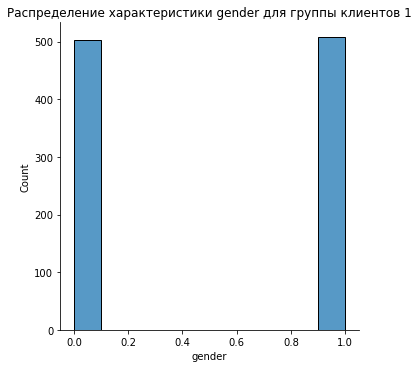

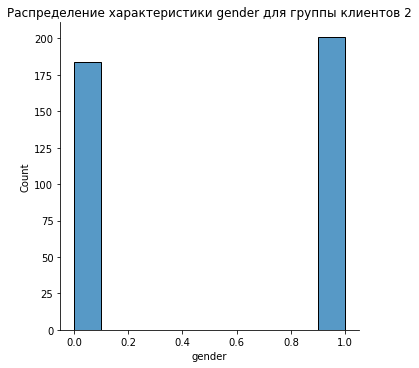

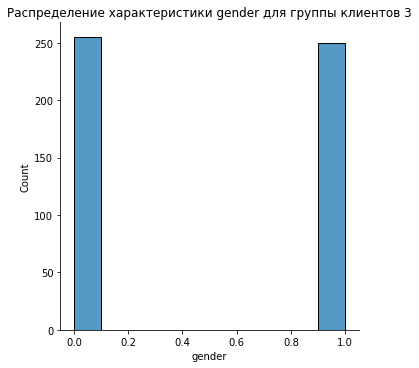

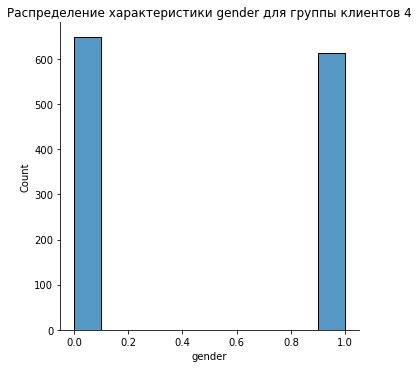

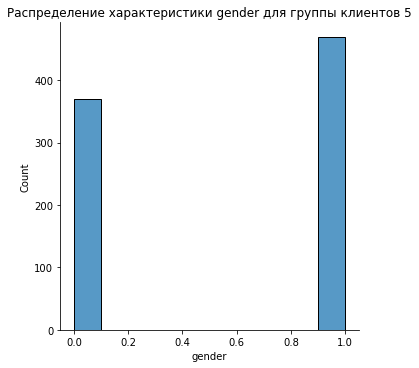

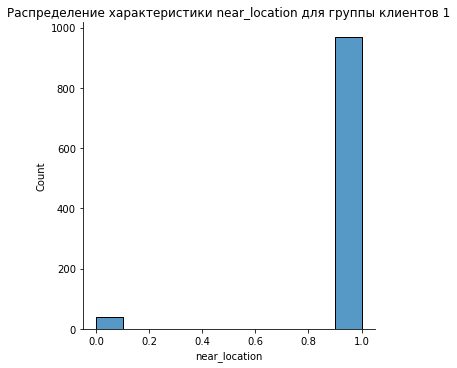

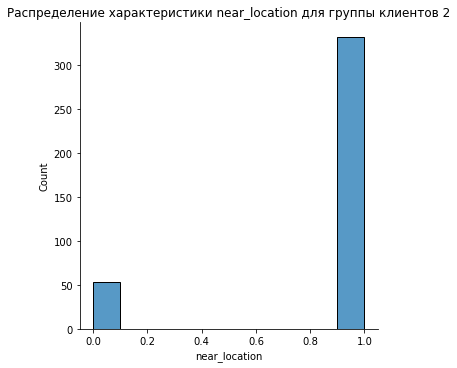

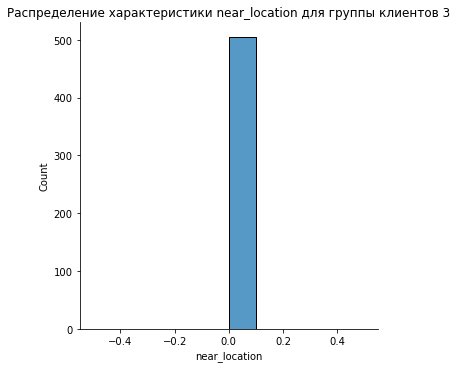

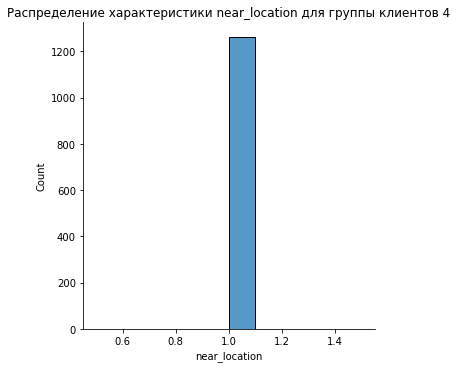

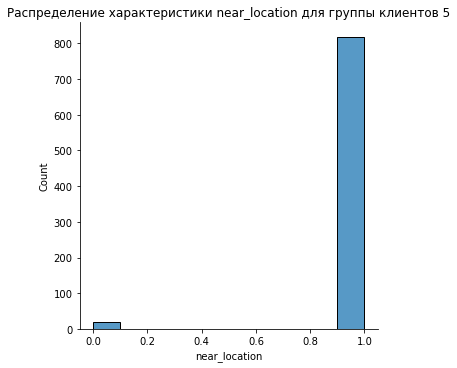

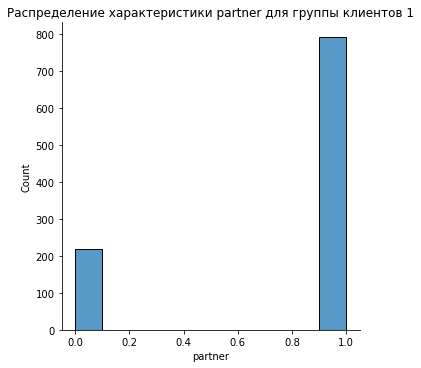

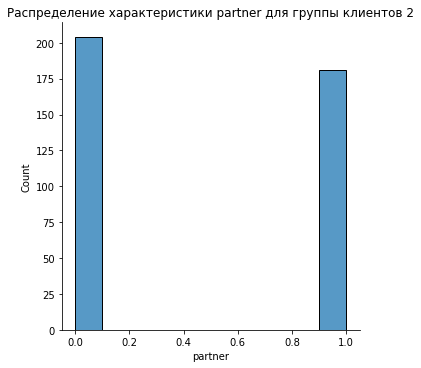

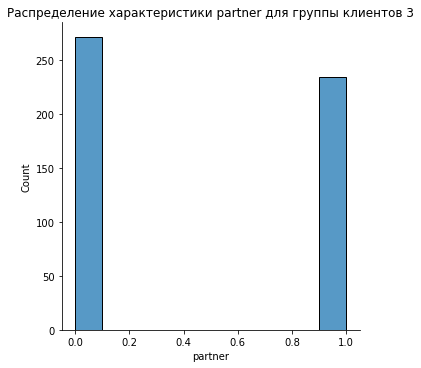

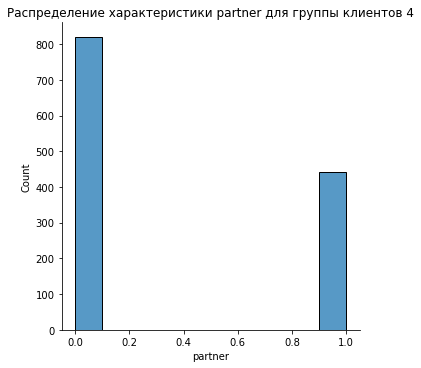

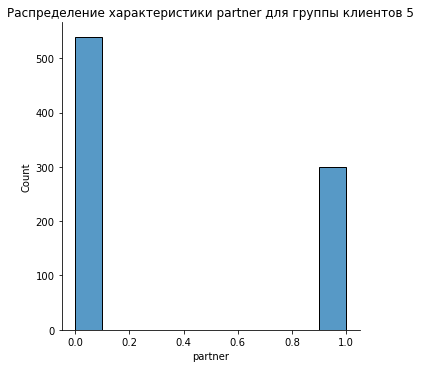

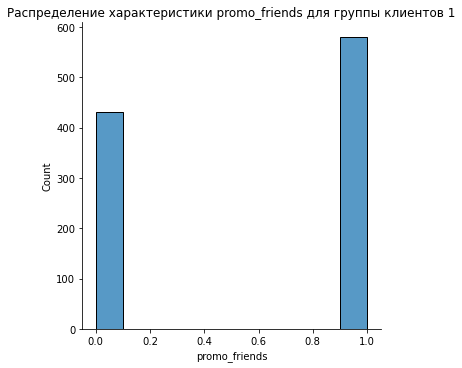

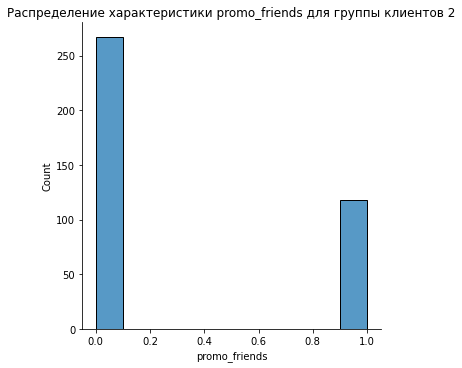

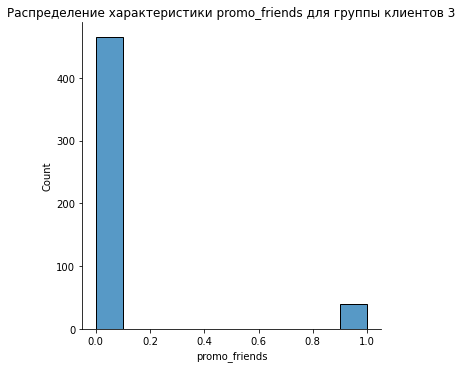

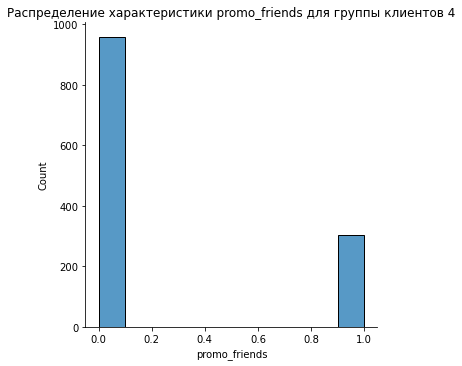

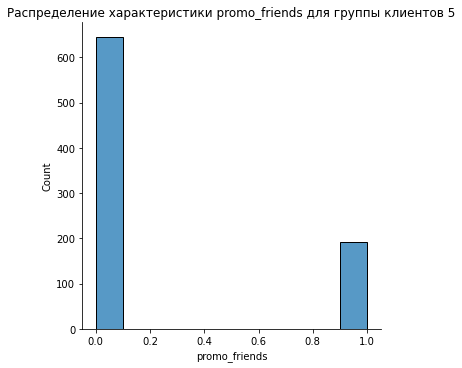

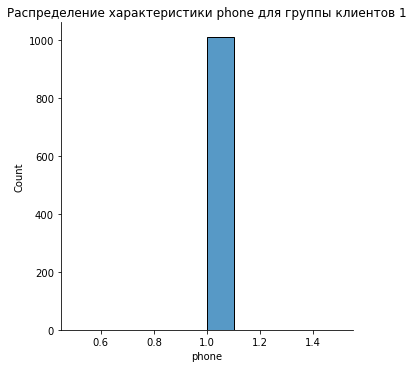

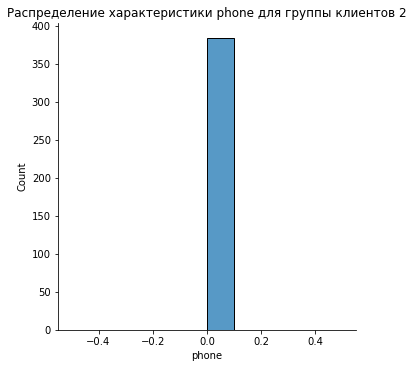

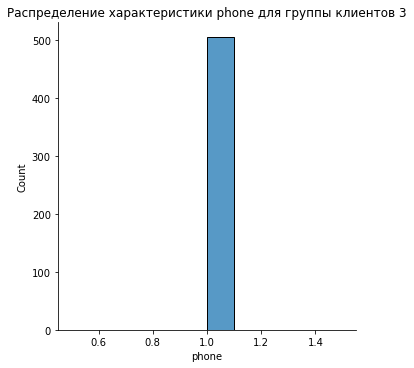

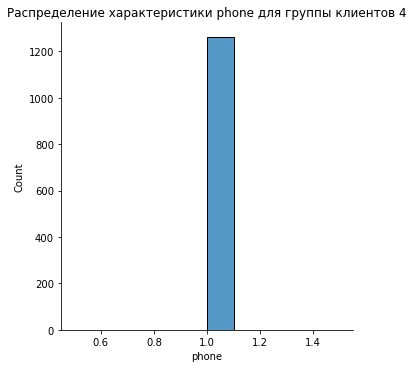

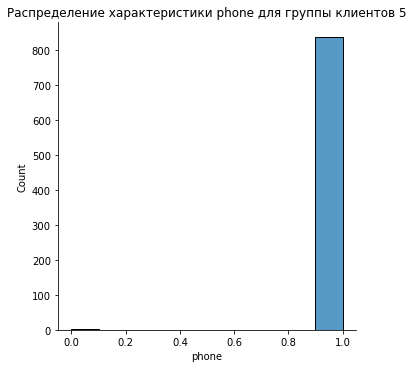

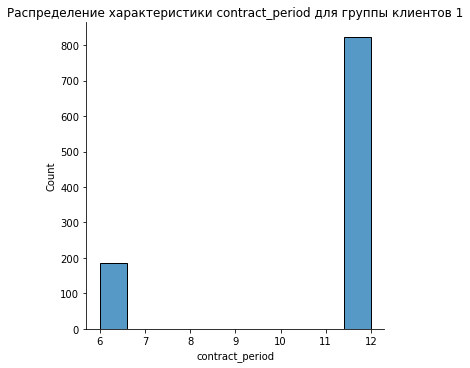

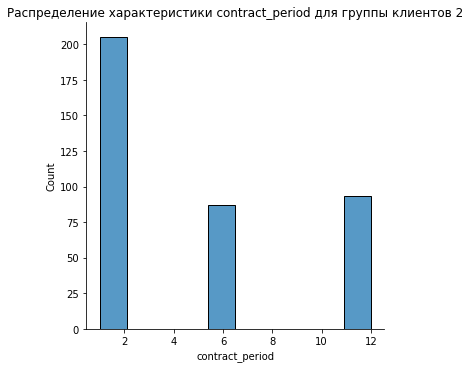

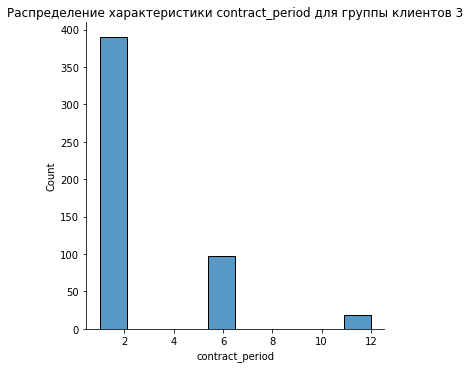

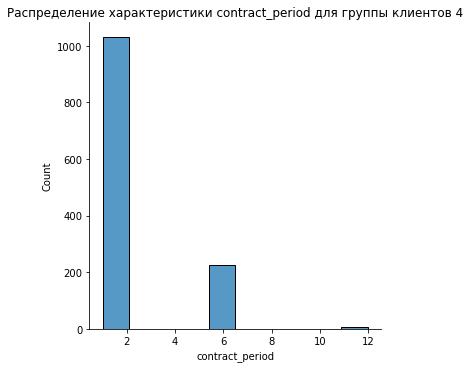

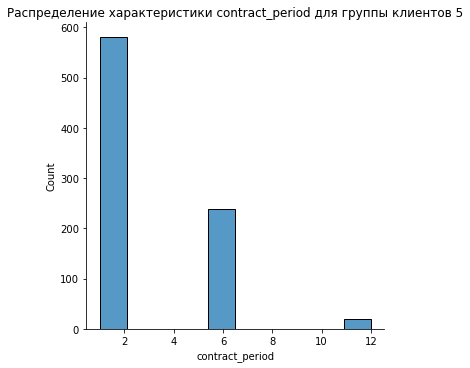

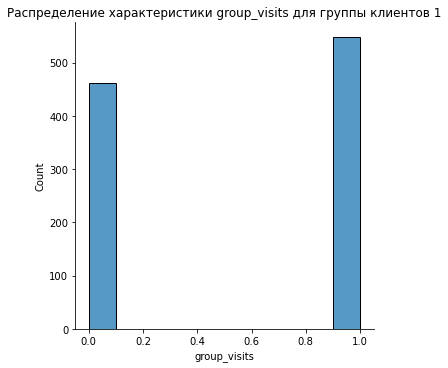

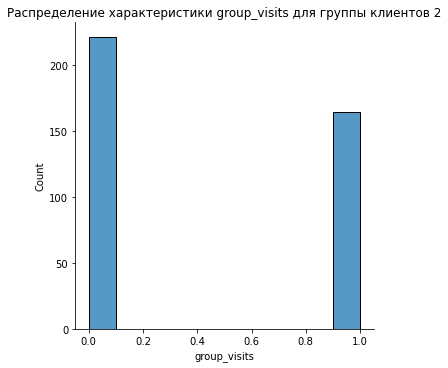

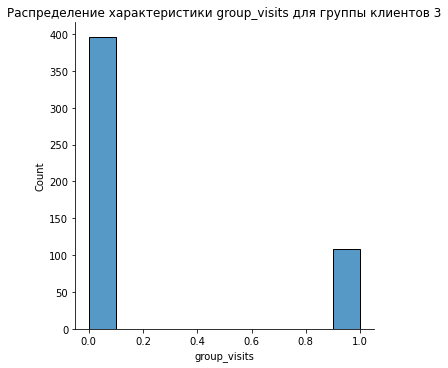

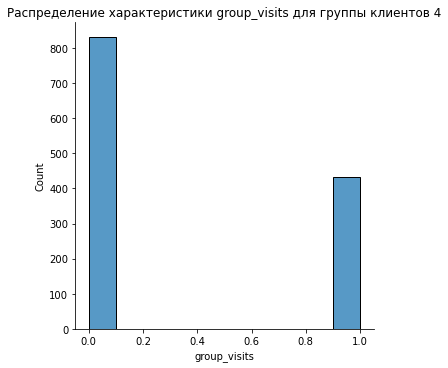

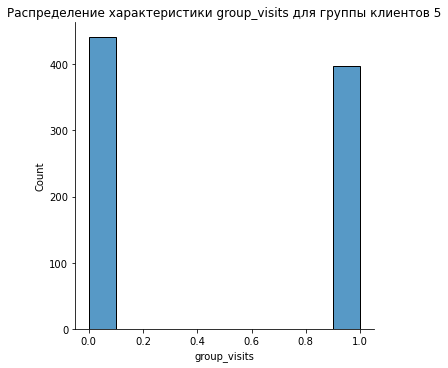

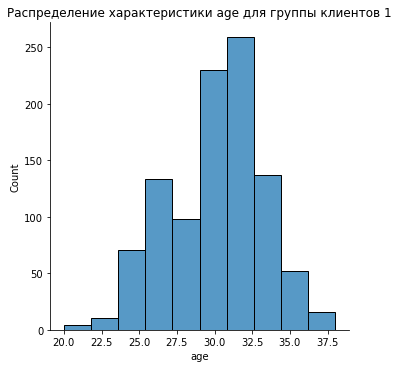

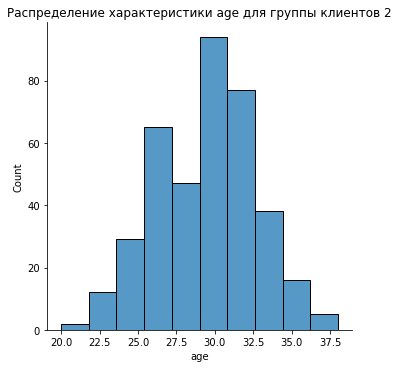

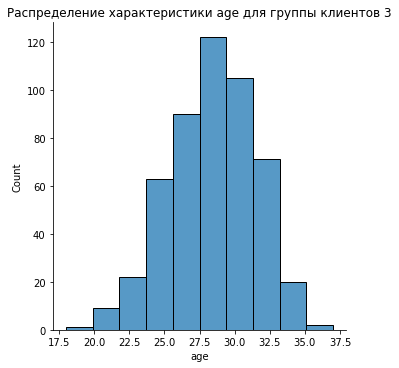

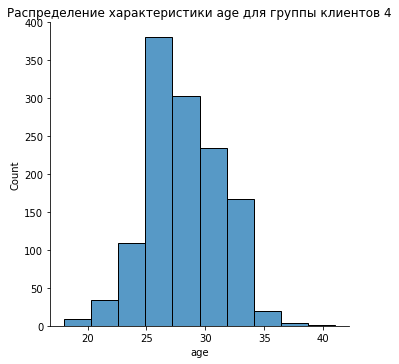

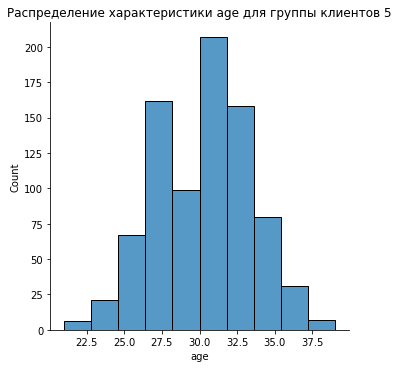

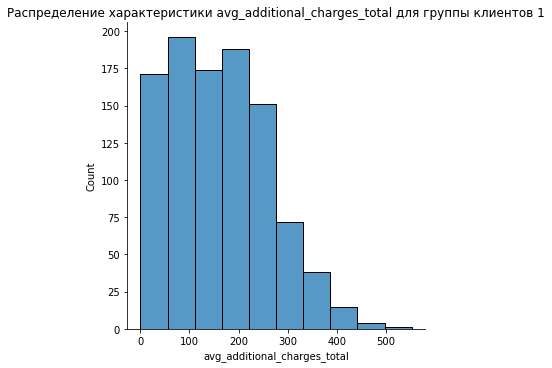

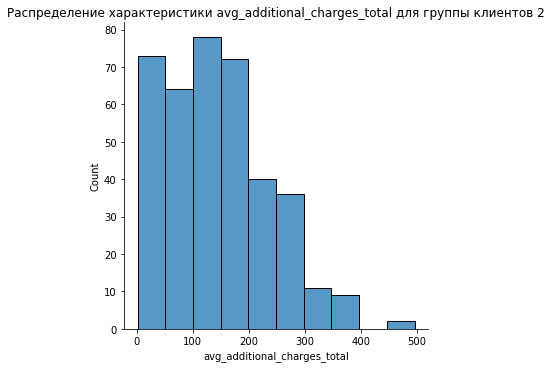

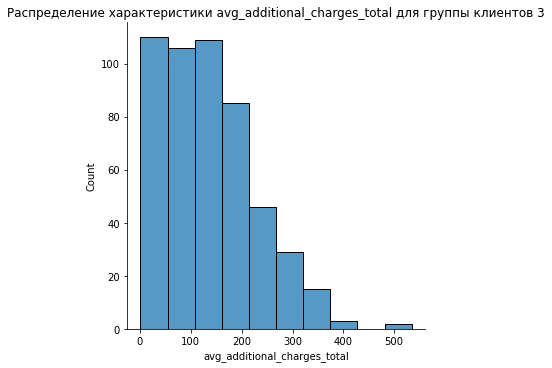

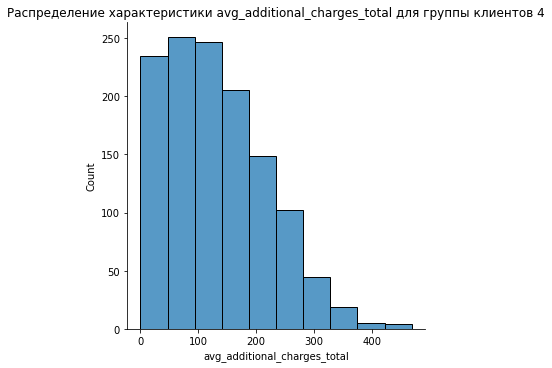

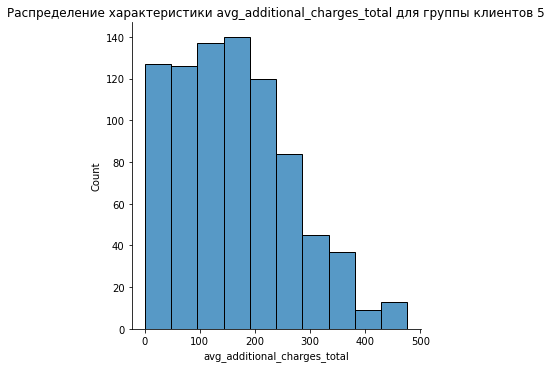

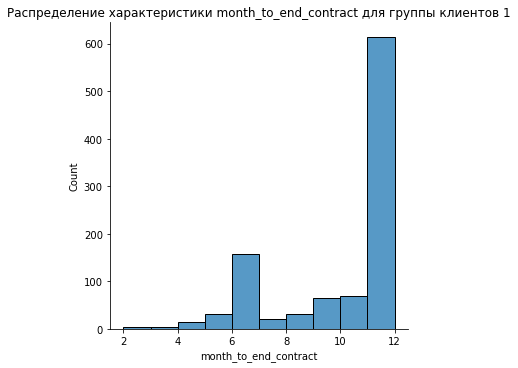

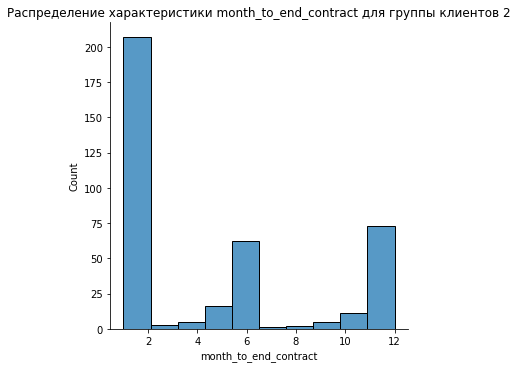

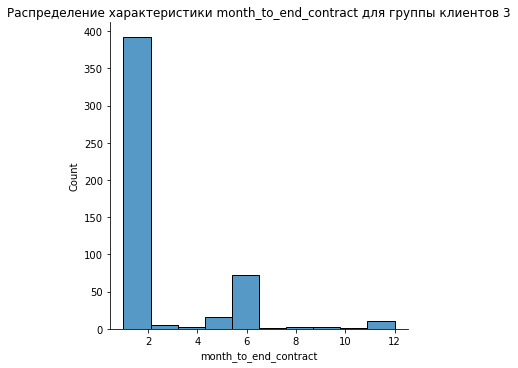

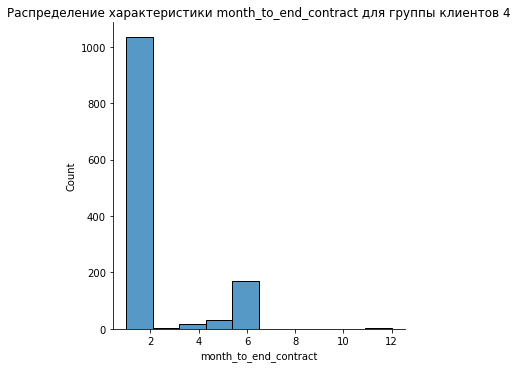

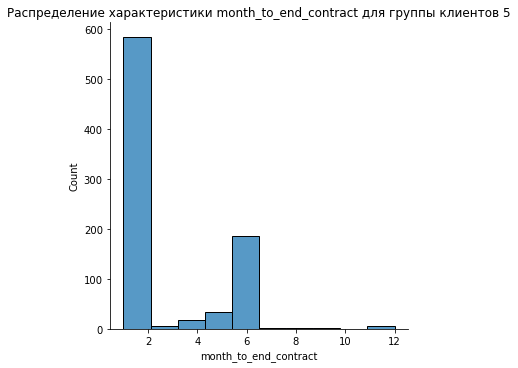

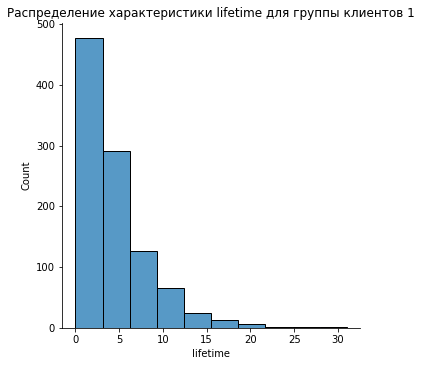

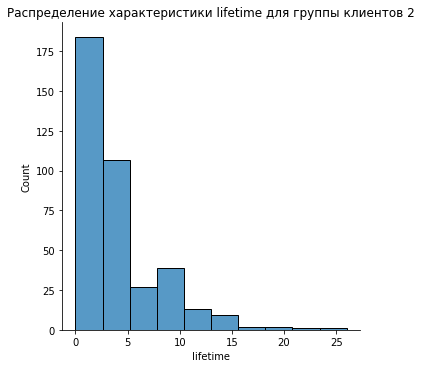

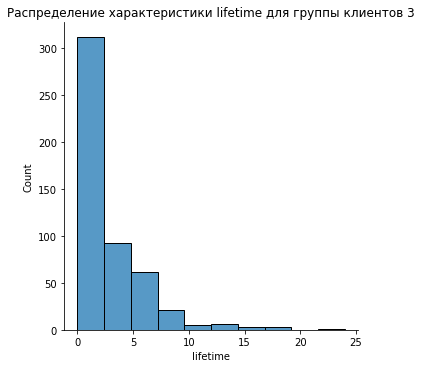

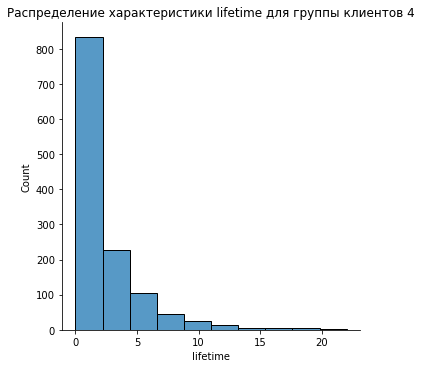

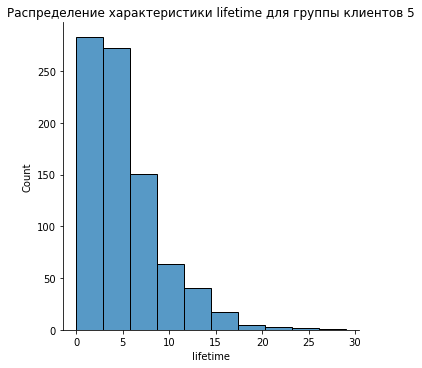

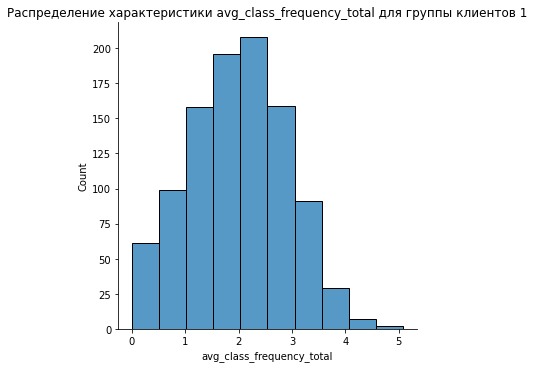

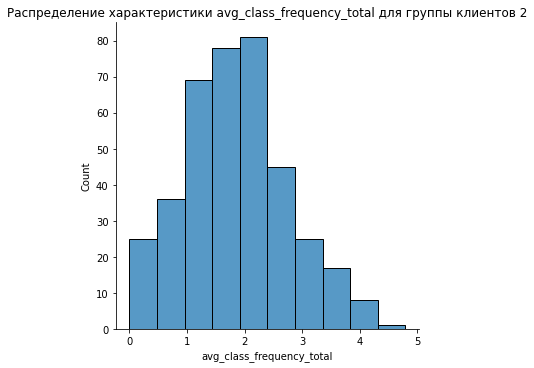

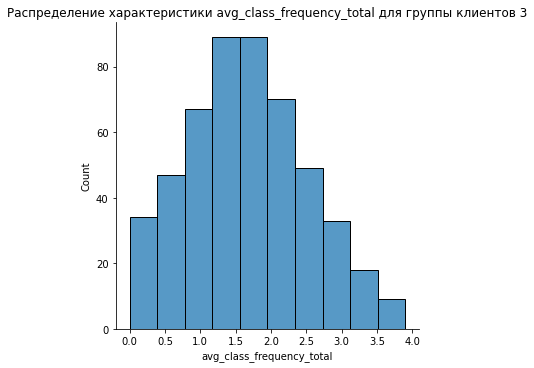

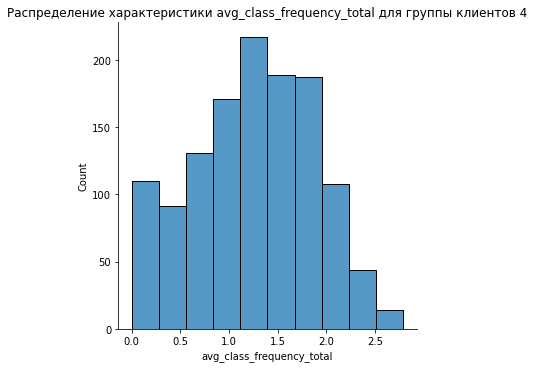

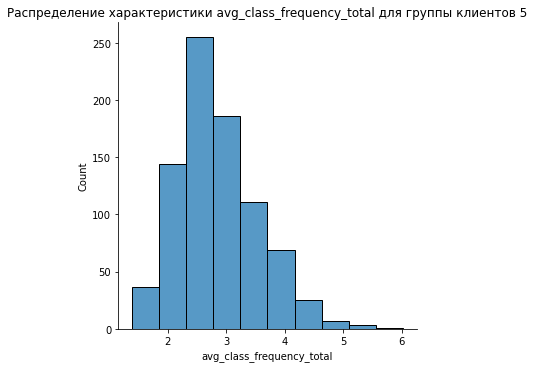

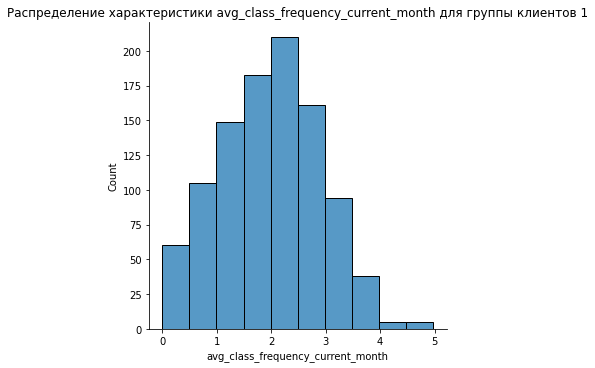

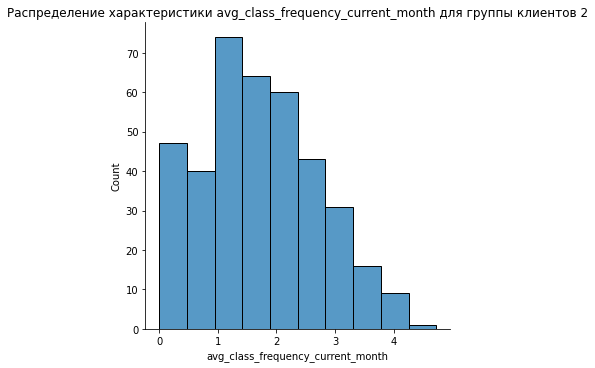

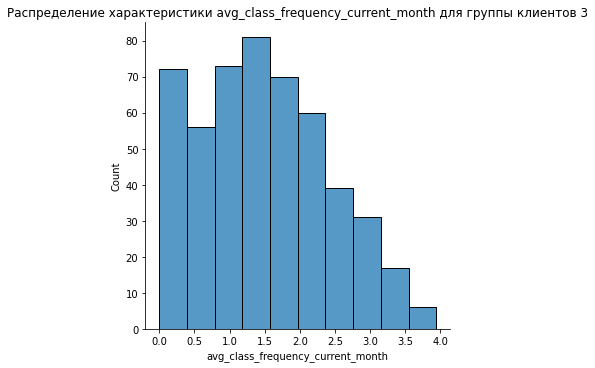

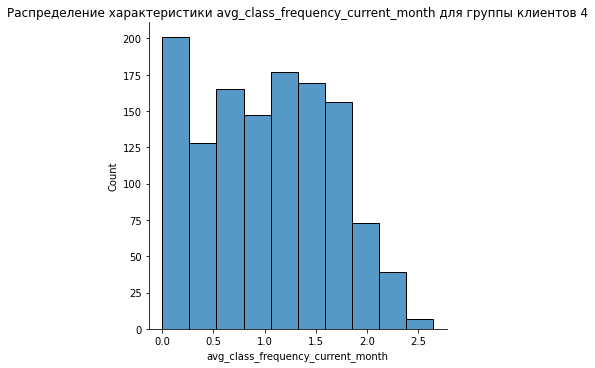

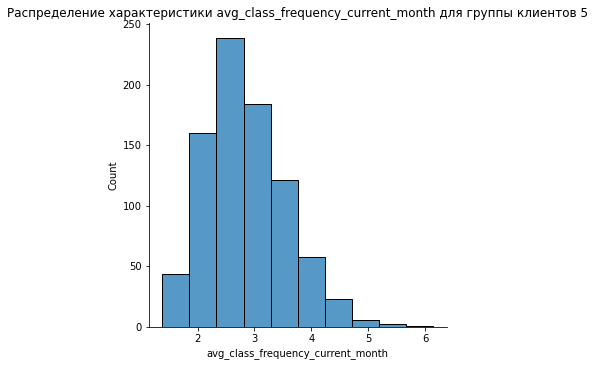

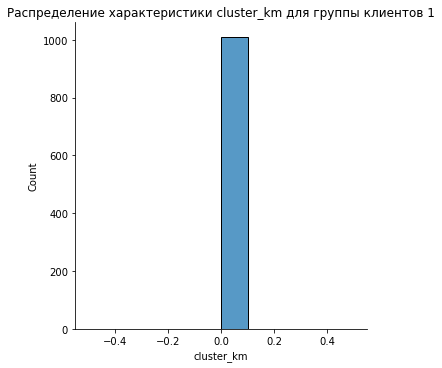

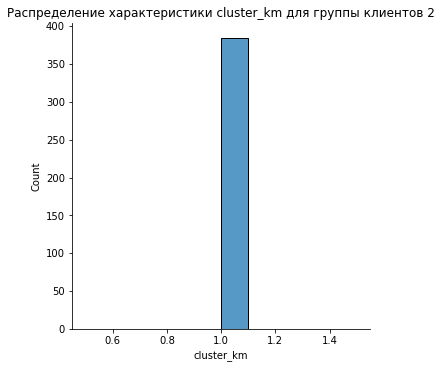

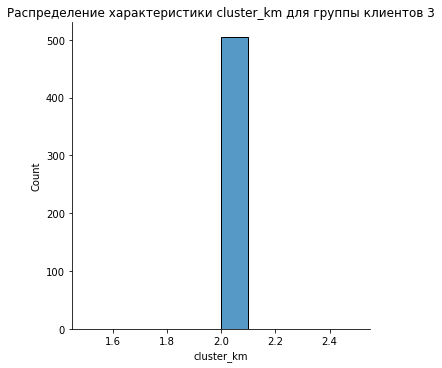

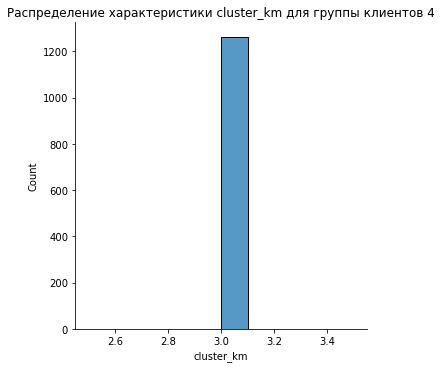

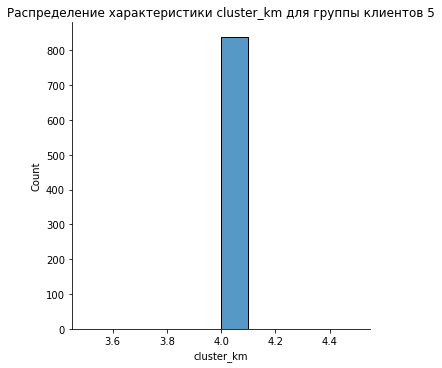

In [34]:
def get_hist(group_col, key_cols):
    gym_new = gym.copy()
    gym_new[key_cols] = gym[key_cols]
    for c in key_cols:
        for cl in sorted(gym[group_col].unique()):
            sns.displot(gym_new[gym_new[group_col]==cl][c], bins = 10)
            plt.title('Распределение характеристики {} для группы клиентов {}'.format(c, cl+1))
get_hist('cluster_km', gym.columns)

Если основываться на ранее полученных наблюдениях, можно предположить, что максимальный отток клиентов характерен для группы 4.  
Проверим это предположение.  
Чтобы сделать это, снова подтянем столбец сhurn - факт оттока клиентов, и посчитаем среднее по группам.  
Дополнительно получим количество клиентов в каждой группе. 

In [35]:
gym['churn'] = gym_churn['churn']
gym_mean = gym.groupby('cluster_km')['churn'].mean().reset_index()
gym_mean['cluster_km'] = gym_mean['cluster_km'] + 1
gym_mean

,cluster_km,churn
0,1,0.03
1,2,0.27
2,3,0.44
3,4,0.51
4,5,0.07


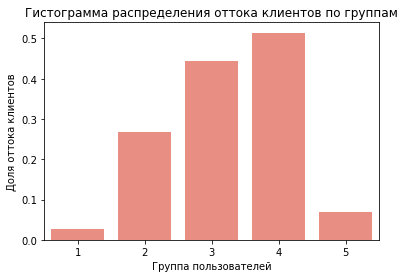

In [36]:
sns.barplot(data=gym_mean, x='cluster_km', y='churn', color="salmon")
plt.title('Гистограмма распределения оттока клиентов по группам')
plt.xlabel('Группа пользователей')
plt.ylabel('Доля оттока клиентов')
plt.show()

In [37]:
gym_count = gym.groupby('cluster_km')['churn'].count().reset_index()
gym_count['cluster_km'] = gym_count['cluster_km'] + 1
gym_count

,cluster_km,churn
0,1,1010
1,2,385
2,3,505
3,4,1262
4,5,838


Наиболее надежными группами клиентов являются группы 1 и 5. Для пользователей этих групп наименее характерен отток. Доля "отскочивших" клиентов в этих группах менее 10%.  
Группа со средними результатами - группа 2. Только четверть клиентов из этой группы перестали пользоваться услугами фитнес-центра.  
Худшие результаты показали группы 3 и 4. Около половины клиентов этих групп (44% и 51%) "отскочили".  

## Выводы
В соответствии с поставленными в начале проекта задачами, была построена модель для прогноза вероятности оттока клиента, сформированны основные группы клиентов и проанализированы характеризующие группы признаки.  

По ходу работы было составлено четыре модели для прогнозирования оттока клиентов.  
Итоговая модель lr_model является моделью логистической регрессии, и построена по всем имеющимся в датафрейме признакам (в т.ч. по коррелирующим между собой).  
Предлагаемая модель  характеризуется следующими показателями, полученными на основе валидационной выборки (800 ранее отфильтрованных строк массива, на которой проверялась построенная модель):  
Accuracy (доля верных положительных и верных отрицательных ответов среди всех полученных результатов): 0.93  
Precision (доля правильных положительных ответов среди всех положительных ответов модели): 0.89  
Recall (доля верных положительных среди всех реально положительных результатов): 0.84  
Характеристика ROC_AUC для этой модели составляет 0,98 при максимальном значении 1.  

Чем ближе указанные выше метрики к единице, тем более качественно модель строит предположения.  
Полученные результаты - сравнительно высокие. Можно говорить о том, что только в 7 случаях из 100 модель даст неверный результат.
При необходимости в более точных прогнозах со стороны заказичка в дальнейшем можно произвести дополнительную оценку качества классификатора.

Далее, в соответствии с заданным ТЗ, все клиенты были разделены на 5 категорий.  
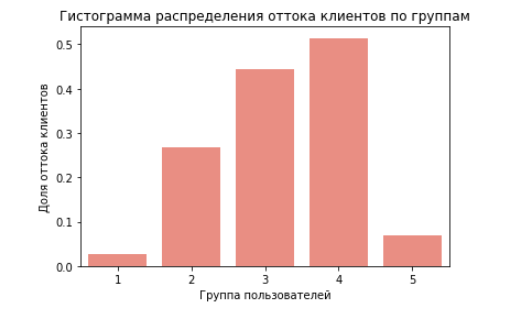
1 группа характеризуется высокой долей привлеченных по промоакции "Приведи друга" клиентов, чаще всего являются сотрудниками партнера клуба, у этой группы клиентов фитнес-центра наиболее длительные контракты (среднее значение более 10 месяцев), они чаще других посещают групповые занятия, их средний возраст приближается к 30 годам, они чаще пользуются сторонними услугами фитнес-центров и посещают клуб (который находится поблизости от места работы или от дома) стабильно в среднем 2 раза в неделю. Это стабильные клиенты, наименее склонные к оттоку (доля оттока клиентов в этой группе 0,03). Это вторая по величине группа пользователей.  
2 группа - клиенты, более склонные к оттоку, чем клиенты 1 группы (доля оттока 0,27), но также самая малочисленная группа пользователей. Наиболее характерная черта этой группы - отсутствие номеров телефонов. Финтес-центр также находится недалеко от работы/от дома, эти пользователи почти в 2 раза реже привлекаются по акции "Приведи друга" и реже являются работниками партнеров клуба. В среднем абонементы этих пользователей действительны прим. в течение 5 месяцев, они также ходят на групповые занятия, но реже тратят дополнительные деньги на прочие услуги фитнес-центра. Среднее кол-во посещений в течение недели чуть менье - в районе 1,8.  

3 и 4 группы пользователей наиболее склонны к оттоку. Основные отличия между группами: у клиентов группы 3 нет поблизости фитнес-центров, они чуть чаще работают в компании-партнере (0,46 - сопоставимо с группой 2), крайне редко привлекаются по акции "Приведи друга" (менее чем в 10% случаев), в среднем их абонементы составлены почти на 2,5 месяца, они реже всех посещают групповые занятия (0,22 пользователей группы), в среднем на них приходится в районе полутора посещений в неделю.  
Клиенты 4 группы реже всего являются работниками компаний-партнеров, их контракты составлены на наиболее короткий промежуток времени, они также редко посещают групповые занятия. Клиенты 4 группы реже всех посещают клуб, и со временем частота посещений падает.    
Средний возраст клиентов обоих групп менее 29 лет, обе группы наименее склонны к дополнительным тратам на прочие услуги. Также можно сказать, что это наиболее "свежие" клиенты (самый низкий показатель по признаку lifetime). При этом группа 4 - наибольшая среди всех по количеству клиентов, а также по доле оттока.  

5 группа имеет сопоставимую с первой группой долю оттока (0,07), по количеству клиентов уступает первой группе чуть меньше, чем на 10%. Их отличие от первой группы - пользователи значительно реже привлекаются по акциям и скидкам, имеют более короткие абонементы и они посещают фитнес-центр чаще всех остальных - почти 3 раза в неделю.  

Основными индикаторами потенциального оттока клиентов можно назвать период контракта, частота посещения групповых занятий, сумма трат на прочие услуги центра, период взаимодействия клиента с клубом (lifetime) и общая частота посещений.  
Также можно обратить внимание на то, что в 4 группе клиентов (наиболее крупной и имеющей наибольшую долю оттока клиентов) меньше всего клиентов-работников партнеров клуба (т.е., скорее всего, не имеющих дополнительную корп. скидку на услуги) и клиенты этой группы в среднем самые молодые из всех групп.  

Рекомендации по взаимодействию с клиентами для их удержания:  
1) Предлагать индивидуальные скидки (сопоставимые, но меньшие, чем для корп.клиентов) для проживающих/работающих поблизости от фитнес-центра клиентов;  
2) Стимулировать клиентов 3 и 4 групп чаще посещать групповые занятия (это, например, позволит таким клиентам завести новые знакомства, что, в свою очередь, позволит увеличить заинтересованность в дальнейших занятиях);  
3) Предлагать выгодные абонементы для клиентов на длительный период;  
4) Следить за частотой посещения фитнес-центра клиентами. При уменьшении частоты посещений в неделю до полутора связываться с клиентом для проведения опроса удовлетворенностью и предложения указанных выше пунктов. 